In [1]:
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
from IPython import display
import cvxpy as cvx
import math
import sys
import time

%matplotlib inline

In [34]:
## Main Functions 

def ISTA(A, b, niter, lamb, x_true=None): 
    # is Complex?
    if isinstance(b[0], complex):
        ATA = np.matrix.getH(A) @ A
        ATb = np.matrix.getH(A) @ b
        ST = SoftThreshComplex
        objval = np.zeros(niter, dtype='complex')
        trueval = np.zeros(niter, dtype='complex')
    else:
        ATA = A.T @ A
        ATb = A.T @ b
        ST = SoftThresh
        objval = np.zeros(niter)
        trueval = np.zeros(niter)
    x_i = ATb.copy()
    t = 1/(L(A))
    for i in range(niter):
        x_i = ST(x_i - 2*t*((ATA @ x_i) - ATb), lamb * t)
        objval[i] = F(A,x_i,b,lamb)
        if (x_true != None):
            trueval[i] = np.linalg.norm(x_i - x_true)
#         if i%100 == 0:    
#             printing(x_i, i, lamb * t )
    return x_i, objval, trueval

def FISTA(A, b, niter, lamb, x_true=None):
    # is Complex?
    if isinstance(b[0], complex):
        ATA = np.matrix.getH(A) @ A
        ATb = np.matrix.getH(A) @ b
        ST = SoftThreshComplex
        objval = np.zeros(niter, dtype='complex')
        trueval = np.zeros(niter, dtype='complex')
    else:
        ATA = A.T @ A
        ATb = A.T @ b
        ST = SoftThresh
        objval = np.zeros(niter)
        trueval = np.zeros(niter)
    l = 1/L(A)
    y = ATb.copy() 
    x_new = y
    t_new = 1
    for i in range(1,niter):
        x_old = x_new
        x_new = ST(y - 2*l*((ATA @ y) - ATb), lamb * l)
        t_old = t_new
        t_new = ( ( 1 + math.sqrt(1 + 4 * t_old * t_old) ) / 2 )
        y = x_new + ( (t_old - 1)/(t_new) ) * ( x_new - x_old )
        objval[i] = F(A,x_new,b,lamb)
        if (x_true != None):
            trueval[i] = np.linalg.norm(x_new - x_true)
    return x_new, objval, trueval

def AMP(A, y, niter, cutoff, x_true=None):
    # Declaring Variables 
    ATy = A.T @ y
    x = np.zeros((niter,len(ATy))) # Estimate
    z = np.zeros((niter,len(y))) # Innovation
    lamb = np.zeros(niter)  # Threshold parameter
    trueval = np.zeros(niter) # Error from True Signal (l-2 norm)
    if isinstance(b[0], complex):
        ST = SoftThreshComplex
        trueval = np.zeros(niter, dtype='complex')
        print('complex')
    else:
        ST = SoftThresh
        trueval = np.zeros(niter)
    weight = (1/A.shape[0]) # 1 / n 
    x[0] = (ATy).copy() * 0 # Initiate estimate
    z[0] = y.copy() * 0 # Initiate innovation
    
    for i in range(1,niter):
        #  Calculating x
        gamma_amp = x[i-1] + A.T @ z[i-1]
        tmp=sorted(abs(gamma_amp), reverse=True)
        lamb[i] = tmp[cutoff]
        x[i] = ST(gamma_amp, lamb[i])
        #  Calculating z
#         z[i] = (y - A @ x[i]) + z[i-1] / (A.shape[0]) * sum(abs(gamma_amp) > lamb[i])
        z[i] = (y - A @ x[i]) + z[i-1] * weight * sum(dST(gamma_amp,lamb[i])) 
        
        if(x_true != None):
            trueval[i] = np.linalg.norm(x_true - x[i])
    return x[-1], trueval

def ADMM(A, y, niter, lamb, x_true=None):
    m, n = A.shape
    np.matrix.getH
    ATA = np.matrix.getH(A) @ A
    ATy = np.matrix.getH(A) @ y
    w = np.linalg.eigvals(ATA)
    ST = SoftThreshComplex 
    
    # Variables to caluculate min 1/2(y - Ax) + l||x|| via alternating direction methods
    x_hat = ATy.copy()
    z_hat = np.zeros(n)
    u = np.zeros(n)
    trueval = np.zeros(niter)
    
    # Calculate regression co-efficient and stepsize
    rho = L(A) 
    lamb_over_rho =  lamb / rho # I might be wrong here
    
    # Pre-compute to save some multiplications
    Q = ATA + rho * np.identity(n)
#     Q = np.linalg.inv(Q)
#     Q_dot = Q.dot
    sign = np.sign
    maximum = np.maximum
    absolute = np.absolute
    lstsq = np.linalg.lstsq

    for i in range(1,niter):
        # x minimization step via posterier OLS
        b = ATy + rho * (z_hat - u)
        x_hat =  lstsq(Q,b)[0]
#         print(x_hat.shape)
        # z minimisation via soft-thresholding
        u = x_hat + u
        z_hat = ST(u, lamb_over_rho)
        # mulitplier update
        u = u - z_hat
        
        if(x_true != None):
            trueval[i] = np.linalg.norm(x_true - x_hat)

    return x_hat, z_hat, trueval

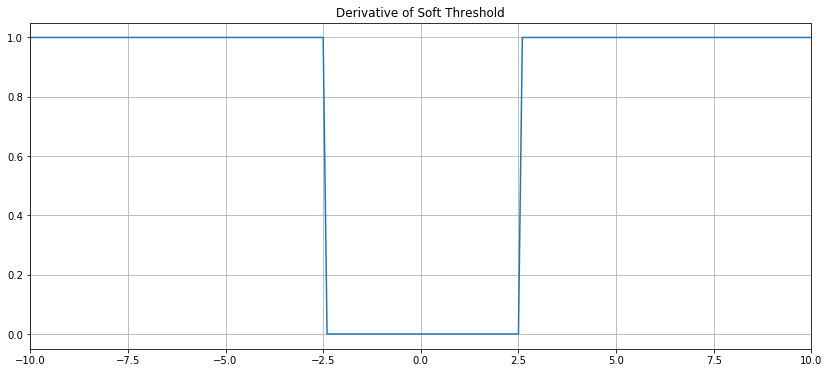

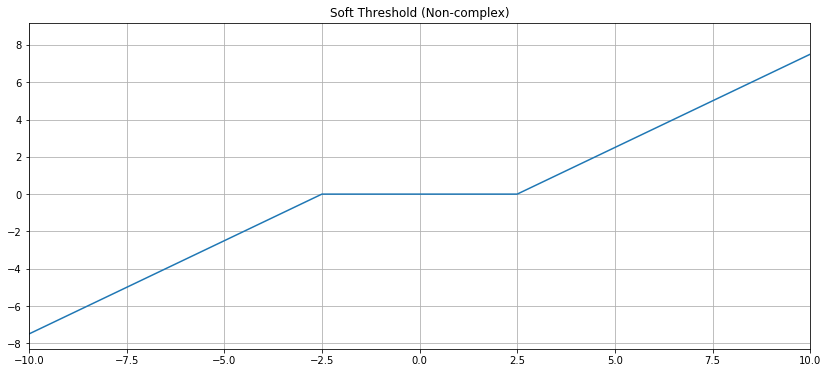

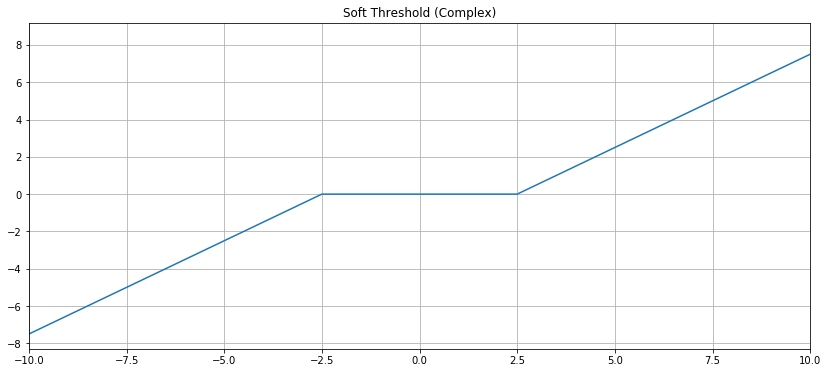

In [3]:
## Paraphernalia

def F(A, x, b, lamb=0):
    f = 0.5 * (np.linalg.norm((A @ x) - b, 2))**2
    g = lamb * np.linalg.norm(x, 1)
    return (f + g)

# Lipschitz's constant for l1 regularization
def L(A):
    return np.real(2*max(np.linalg.eigvals(A.T@A)))

# SoftThresh -- Apply Soft Threshold to y
def SoftThresh(y, lamb):
    res = np.abs(y) - lamb
    xhat = res * np.sign(y)
    xhat[res < 0] = 0.
    return xhat

def SoftThreshComplex(y, lamb):
    res = np.abs(y)
    res = np.maximum(0,(res - lamb)) / res
    return y * res

# Derivative of soft-threshold
# 1 | (c<y ∧ y>=0) ∨ (y<0 ∧ y<-c)
# 0 | (otherwise)
def dST(y, lamb):
    res = np.abs(y) - lamb
    xhat = res
    xhat[res < 0] = 0
    xhat[res > 0] = 1
    return xhat

# Stem plot printing 
def printing(x,i,lamb):
    plt.clf()
    plt.stem(x)
    plt.title( 'Iteration {}, lambda {}'.format(i,lamb) )
    display.clear_output(wait=True)
    display.display(plt.gcf())

# plotting tests
idx = np.arange(-10, 11, .1)
plt.figure(figsize=(14, 6))
plt.plot(idx, dST(idx, 2.5))
plt.xlim((-10, 10))
plt.title('Derivative of Soft Threshold')
plt.grid()

plt.figure(figsize=(14, 6))
plt.plot(idx, SoftThresh(idx, 2.5))
plt.xlim((-10, 10))
plt.title('Soft Threshold (Non-complex)')
plt.grid()

idxc = 1j*np.arange(-10, 11, .1)
plt.figure(figsize=(14, 6))
plt.plot(idx, np.imag(SoftThreshComplex(idxc, 2.5)))
plt.xlim((-10, 10))
plt.title('Soft Threshold (Complex)')
plt.grid()

# Signal Reconstruction
### Noiseless reconstruction

1.0
(96.106036666+0j)


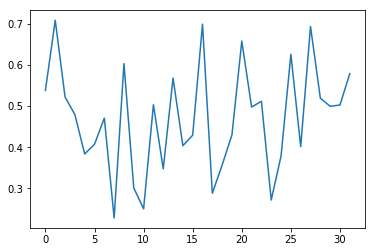

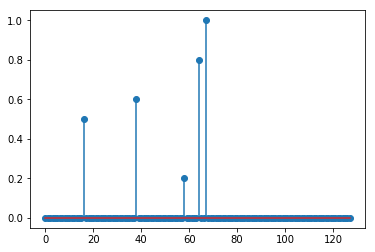

In [4]:
## Problem data
np.random.seed(0)
N = 128
n = 32
x = np.array(  [0.2, 0.5, 0.6, 0.8, 1] + [0] * (N-5))
x = x[ np.random.permutation(N) - 1 ]
A = np.random.rand(n,N)

# Normalize A
A_norm = np.sqrt((A**2).sum(axis=0))
A = A / A_norm[None, :]

b = A @ x
plt.plot(b)
plt.figure()
plt.stem(x)

gamma = 0

print(str(np.linalg.norm(A[:,1])))
print(str(np.max(np.linalg.eigvals(A.T @ A))))

cvx prob.value = 1.979947295612663e-12


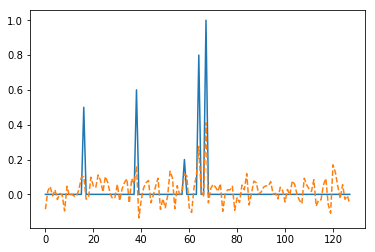

In [5]:
## CVXPY
_x = cvx.Variable(N)
obj = cvx.Minimize( 0.5*((cvx.norm(A@_x - b, 2))**2) + gamma*cvx.norm(_x,1) )
prob = cvx.Problem(obj)
prob.solve()
x_cvx = _x.value

print("cvx prob.value = " + str(prob.value))
plt.plot(range(N), x, range(N), x_cvx, '--')

numpy ls: 6.99343681406e-30
cvx: 5.75586504667e-28


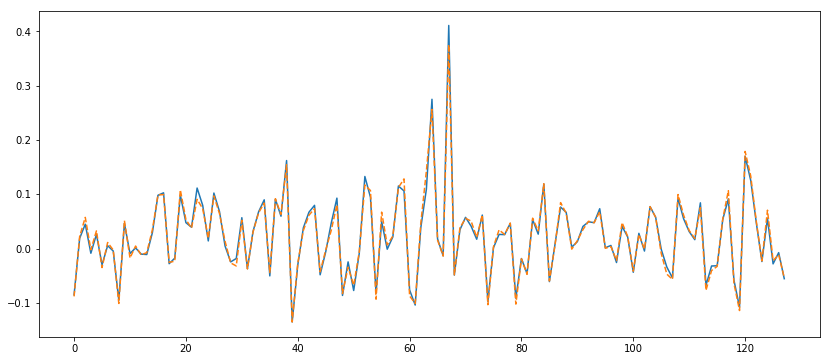

In [6]:
## LEAST SQUARES
x_ls = np.linalg.lstsq(A, b)[0]
x_cvx = np.ravel(x_cvx)
ls = F(A,x_ls,b, gamma) 
cv = F(A,x_cvx,b, gamma)

print("numpy ls: " +str(ls))
print("cvx: " + str(cv))

plt.figure(figsize=(14, 6))
plt.plot(range(N), x_cvx, range(N), x_ls, '--');

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ISTA runtime for 20000 iterations: 1.3828411102294922 seconds
F(x_ist) = 5.45307804454e-30
F(x_cvx) = 5.75586504667e-28


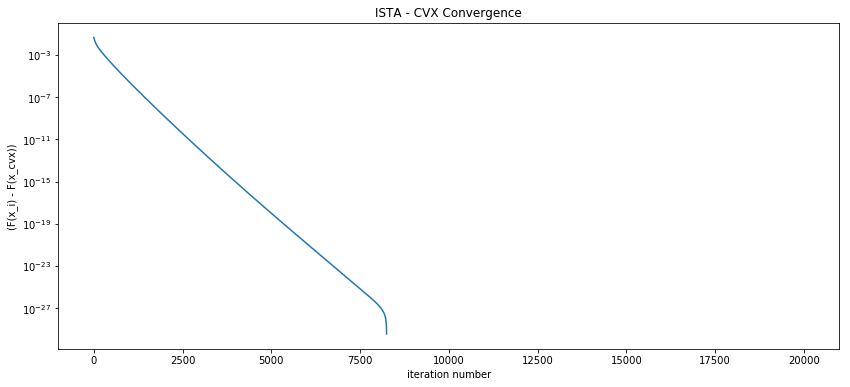

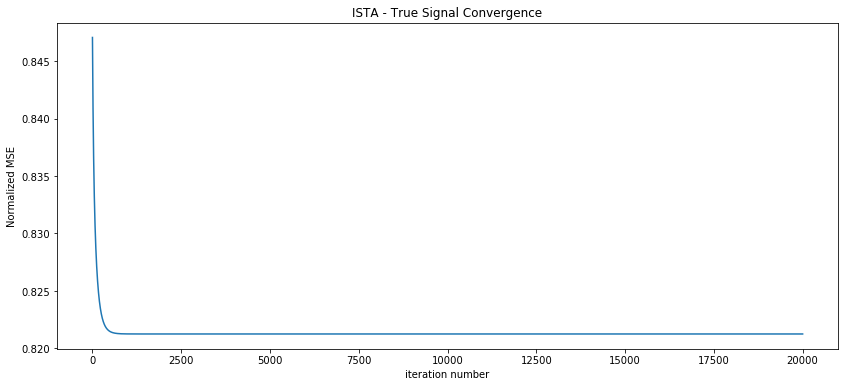

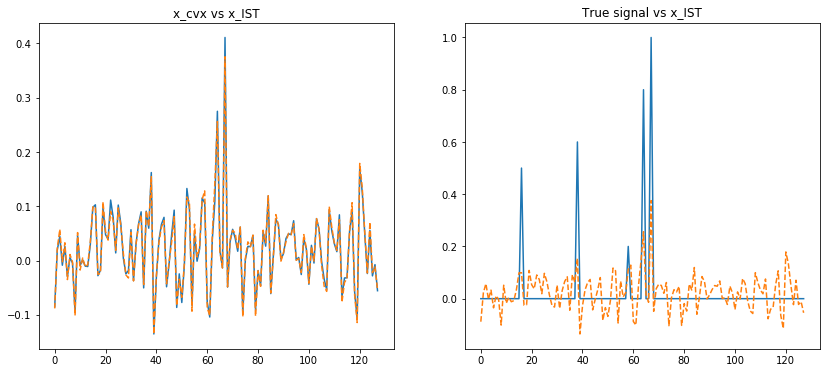

In [7]:
## ISTA

nitr = 20000
tic = time.time()
x_IST, F_IST, TSE_IST = ISTA(A, b, nitr, gamma, x)
toc = time.time()
print('ISTA runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
ist = F(A, x_IST, b, gamma)

plt.figure(figsize=(14, 6))
plt.semilogy(F_IST - F(A, x_cvx, b, gamma))
plt.xlabel('iteration number')
plt.ylabel('(F(x_i) - F(x_cvx))')
plt.title('ISTA - CVX Convergence')

if sum(TSE_IST) > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(TSE_IST/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('ISTA - True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_cvx)
plt.plot(range(N), x_IST, '--')
plt.title('x_cvx vs x_IST')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_IST, '--')
plt.title('True signal vs x_IST')

print('F(x_ist) =', ist)
print('F(x_cvx) =', cv)

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


FISTA runtime for 12000 iterations: 0.9450039863586426 seconds
F(x_fista) = 5.54860416978e-30
F(x_cvx) = 5.75586504667e-28


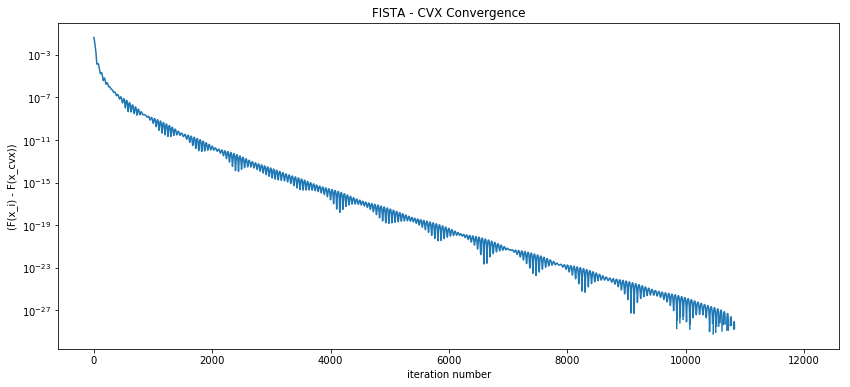

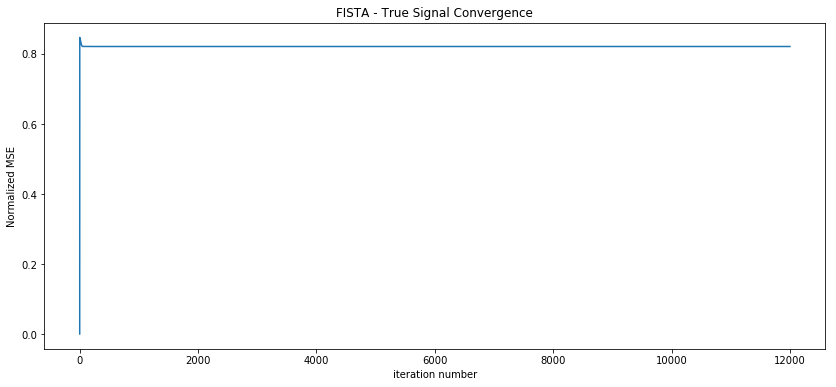

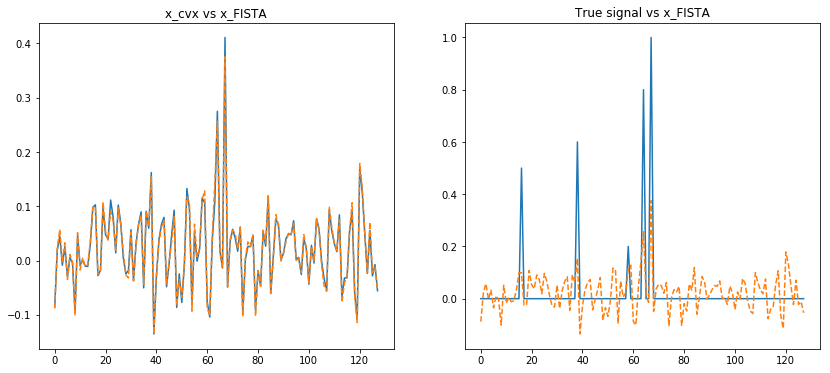

In [8]:
## FISTA

nitr = 12000
tic = time.time()
x_FISTA, F_FISTA, TSE_FISTA = FISTA(A, b, nitr, gamma, x)
toc = time.time()
fista = F(A, x_FISTA, b, gamma)
print('FISTA runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.stem(x_IST)
plt.figure(figsize=(14, 6))
plt.semilogy(F_FISTA - F(A, x_cvx, b, gamma))
plt.xlabel('iteration number')
plt.ylabel('(F(x_i) - F(x_cvx))')
plt.title('FISTA - CVX Convergence')

if sum(TSE_FISTA) > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(TSE_FISTA/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('FISTA - True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_cvx)
plt.plot(range(N), x_FISTA, '--')
plt.title('x_cvx vs x_FISTA')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_FISTA, '--')
plt.title('True signal vs x_FISTA')

print('F(x_fista) =', fista)
print('F(x_cvx) =', cv)

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:85: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


AMP runtime for 200 iterations: 0.04939699172973633 seconds
2-norm(x-x_AMP) = 1.10286715785e-08


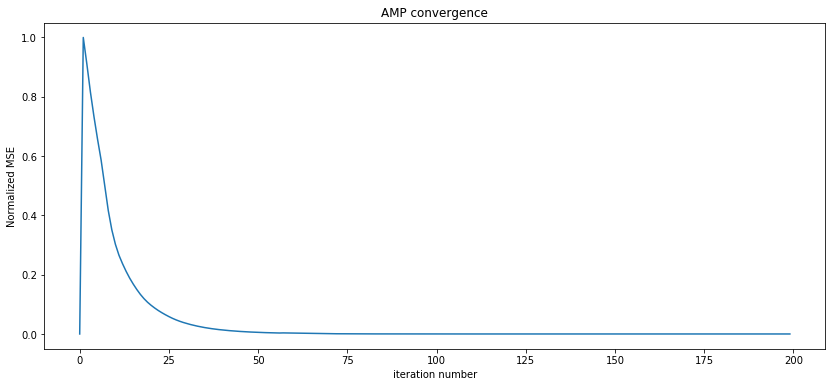

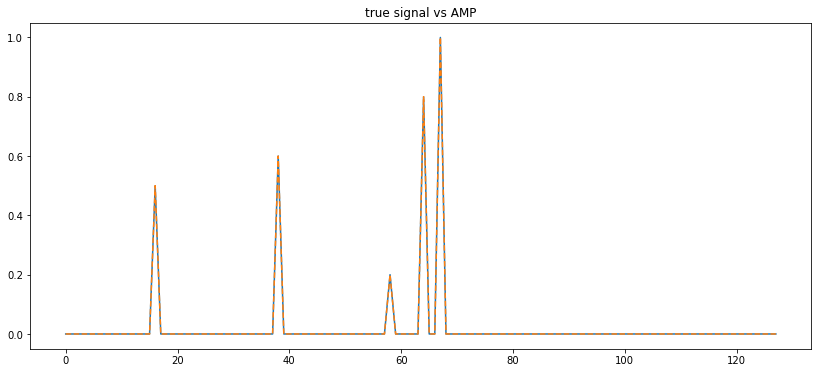

In [9]:
## AMP

nitr = 200
cutoff = 19
tic = time.time()
x_AMP, TSE_AMP = AMP(A, b, nitr, cutoff, x)
toc = time.time()
# amp = F(A, x_AMP, b, gamma)
print('AMP runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.stem(x_AMP)
plt.figure(figsize=(14, 6))
plt.plot(TSE_AMP/np.linalg.norm(x))
plt.xlabel('iteration number')
plt.ylabel('Normalized MSE')
plt.title('AMP convergence')

plt.figure(figsize=(14, 6))
plt.plot(range(N), x, range(N), x_AMP, '--')
plt.title('true signal vs AMP')

print('2-norm(x-x_AMP) =', np.linalg.norm(x - x_AMP))
# print('F(x_cvx) =', cv)


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ADMM runtime for 10000 iterations: 16.592346906661987 seconds
F(x_ADMM) = 2.35335396184e-18
F(z_ADMM) = 2.35335396184e-18
F(x_cvx) = 5.75586504667e-28


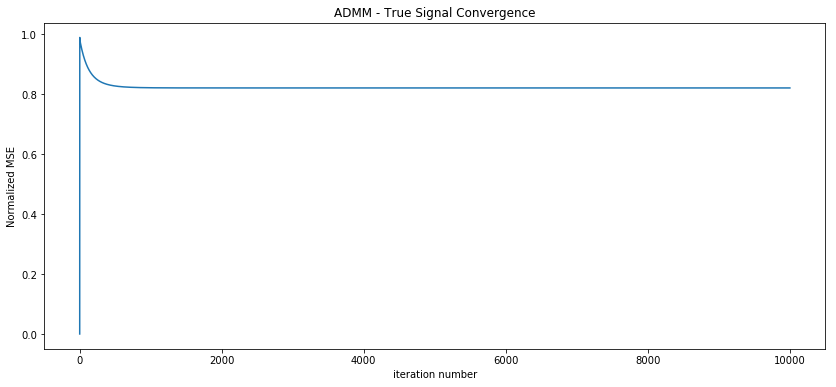

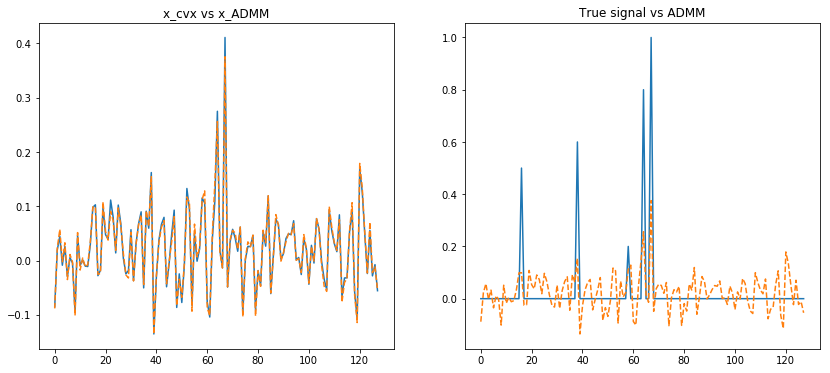

In [10]:
## def ADMM(A, y, niter, lamb, x_true=None):

nitr = 10000
tic = time.time()
x_ADMM, z_ADMM, TSE_ADMM = ADMM(A, b, nitr, gamma, x)
toc = time.time()
admm = F(A, x_ADMM, b, gamma)
print('ADMM runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.figure(figsize=(14, 6))
# plt.plot(range(nitr),admm - F(A, x_cvx, b, gamma))
# plt.xlabel('iteration number')
# plt.ylabel('(F(x_i) - F(x_cvx))')
# plt.title('ADMM - CVX Convergence')

if sum(TSE_ADMM) > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(TSE_ADMM/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('ADMM - True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_cvx)
plt.plot(range(N), x_ADMM, '--')
plt.title('x_cvx vs x_ADMM')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_ADMM, '--')
plt.title('True signal vs ADMM')

print('F(x_ADMM) =', admm)
print('F(z_ADMM) =', F(A, z_ADMM, b, gamma))
print('F(x_cvx) =', cv)

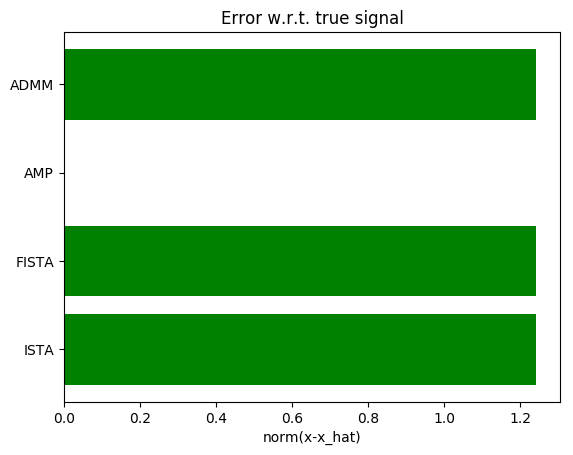

In [11]:
## Error from true signal:

# Benchmarks

plt.rcdefaults()
fig, ax = plt.subplots()

## data
ISTA_error = np.linalg.norm(x - x_IST)
FISTA_error = np.linalg.norm(x - x_FISTA)
AMP_error = np.linalg.norm(x - x_AMP)
ADMM_error = np.linalg.norm(x - x_ADMM)

methods = ('ISTA', 'FISTA', 'AMP', 'ADMM')
y_pos = np.arange(len(methods))
error = [ISTA_error, FISTA_error, AMP_error, ADMM_error]

## barh 
ax.barh(y_pos, error, color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(methods)
ax.set_xlabel('norm(x-x_hat)')
ax.set_title('Error w.r.t. true signal')
plt.show()

### Noisy reconstruction

<Container object of 3 artists>

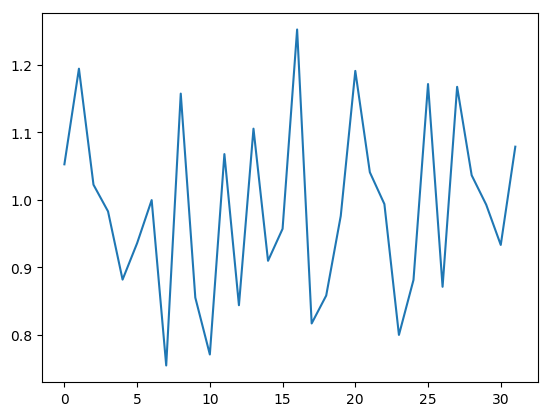

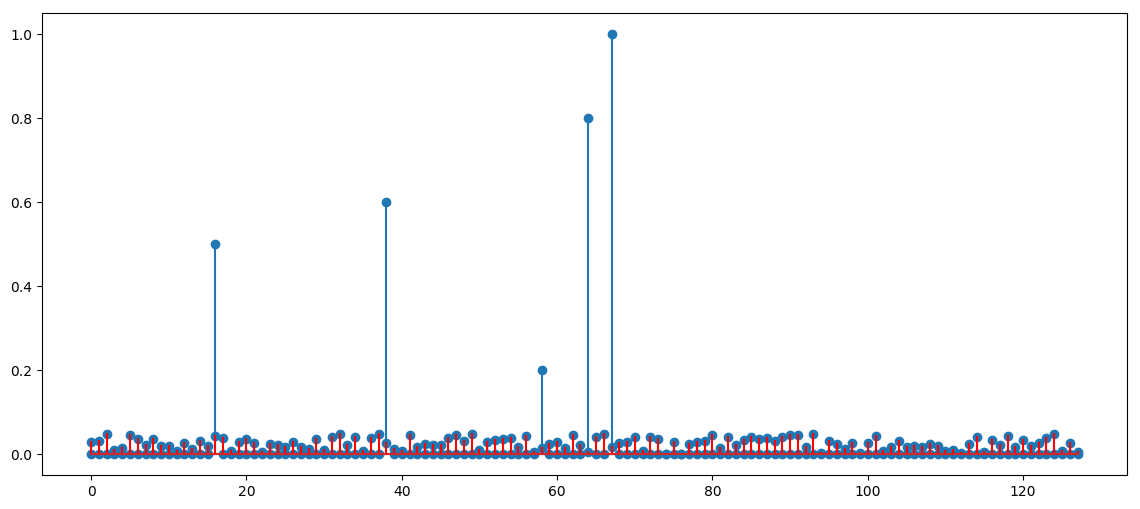

In [12]:
## Problem data
y = x + 0.05 * np.random.rand(128)
b = A @ y
plt.plot(b)
plt.figure(figsize=(14,6))
plt.stem(x)
plt.stem(y-x,'r')

cvx prob.value = 1.98147763966614e-12


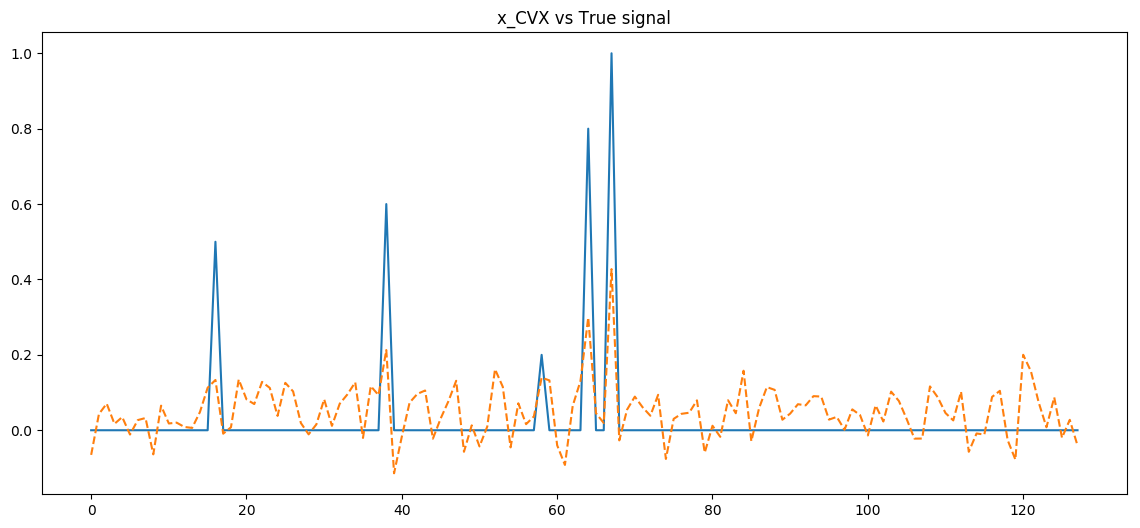

In [13]:
## CVXPY
_x = cvx.Variable(N)
obj = cvx.Minimize( 0.5*((cvx.norm(A@_x - b, 2))**2) + gamma*cvx.norm(_x,1) )
prob = cvx.Problem(obj)
prob.solve()
x_cvx = _x.value

print("cvx prob.value = " + str(prob.value))

plt.figure(figsize=(14, 6))
plt.plot(range(N), x)
plt.plot(range(N), x_cvx, '--')
plt.title('x_CVX vs True signal')

numpy ls: 6.54508032301e-30
cvx: 5.9205243532e-28


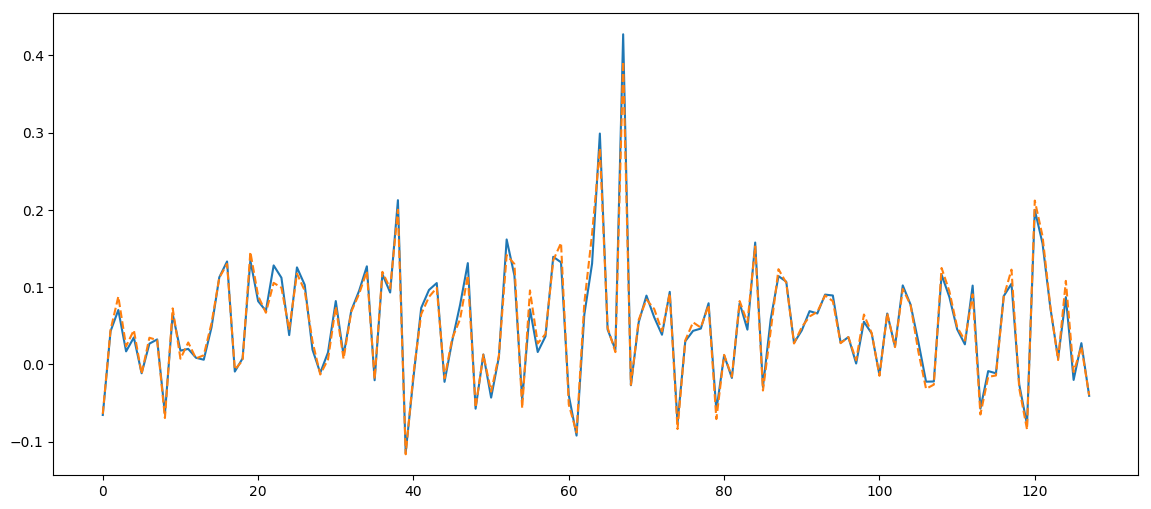

In [14]:
## LEAST SQUARES
x_ls = np.linalg.lstsq(A, b)[0]
x_cvx = np.ravel(x_cvx)
ls = F(A,x_ls,b, gamma) 
cv = F(A,x_cvx,b, gamma)

print("numpy ls: " +str(ls))
print("cvx: " + str(cv))

plt.figure(figsize=(14, 6))
plt.plot(range(N), x_cvx, range(N), x_ls, '--');

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ISTA runtime for 200000 iterations: 12.596885204315186 seconds
F(x_ist) = 1.23012997408e-29
F(x_cvx) = 5.9205243532e-28


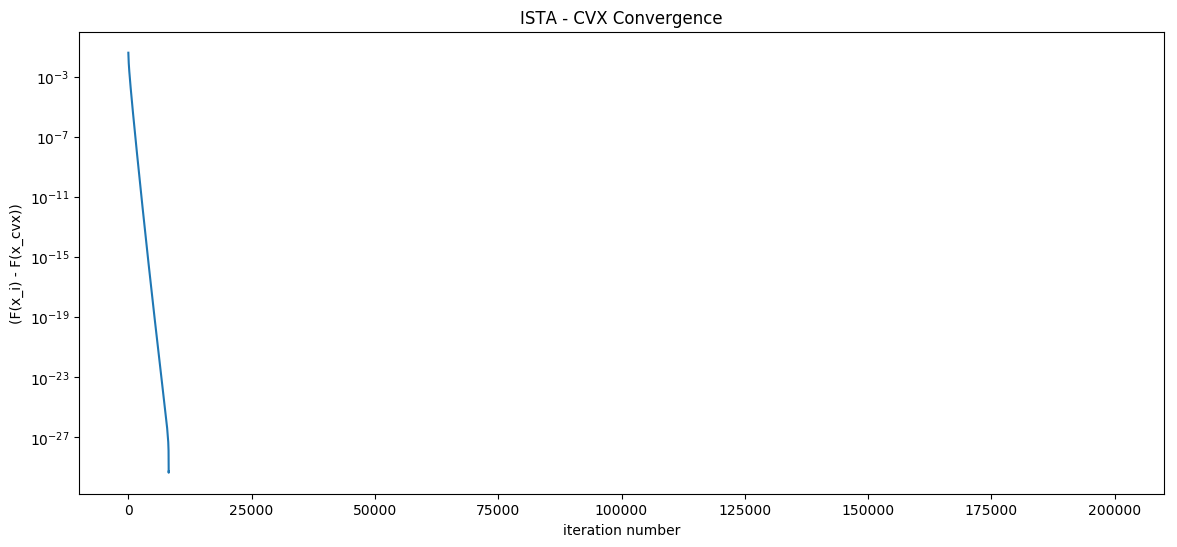

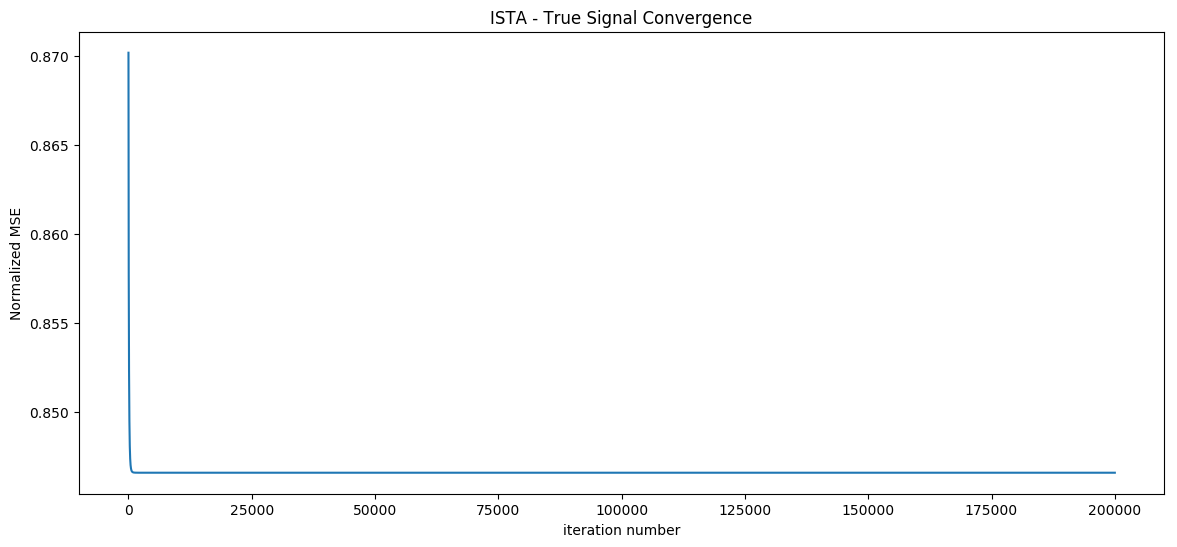

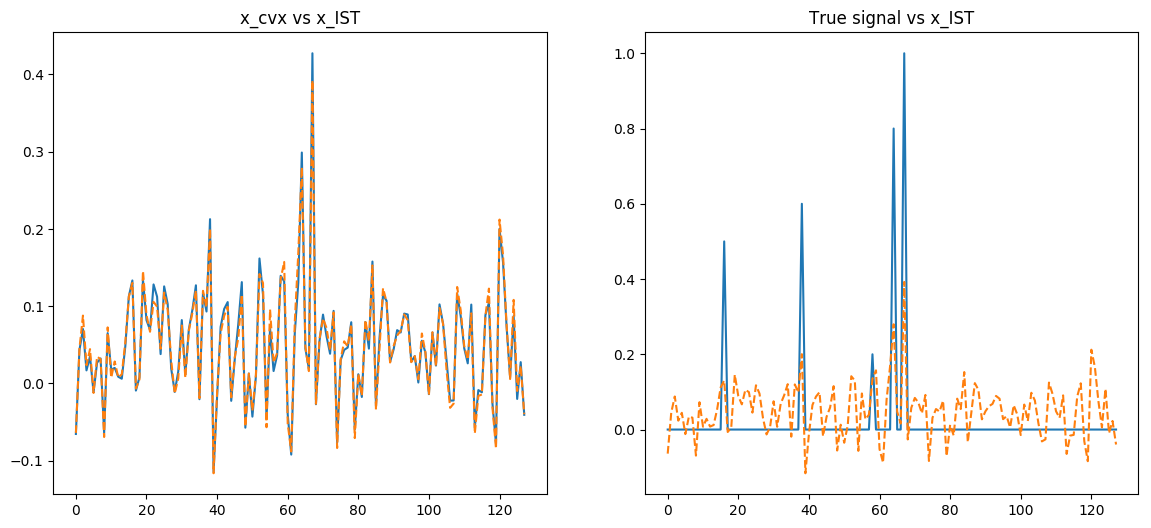

In [15]:
## ISTA

nitr = 200000
tic = time.time()
x_IST, F_IST, TSE_IST = ISTA(A, b, nitr, gamma, x)
toc = time.time()
print('ISTA runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
ist = F(A, x_IST, b, gamma)

plt.figure(figsize=(14, 6))
plt.semilogy(F_IST - F(A, x_cvx, b, gamma))
plt.xlabel('iteration number')
plt.ylabel('(F(x_i) - F(x_cvx))')
plt.title('ISTA - CVX Convergence')

if sum(TSE_IST) > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(TSE_IST/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('ISTA - True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_cvx)
plt.plot(range(N), x_IST, '--')
plt.title('x_cvx vs x_IST')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_IST, '--')
plt.title('True signal vs x_IST')

print('F(x_ist) =', ist)
print('F(x_cvx) =', cv)

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


FISTA runtime for 10000 iterations: 1.403796911239624 seconds
F(x_fista) = 6.16652569611e-27
F(x_cvx) = 5.9205243532e-28


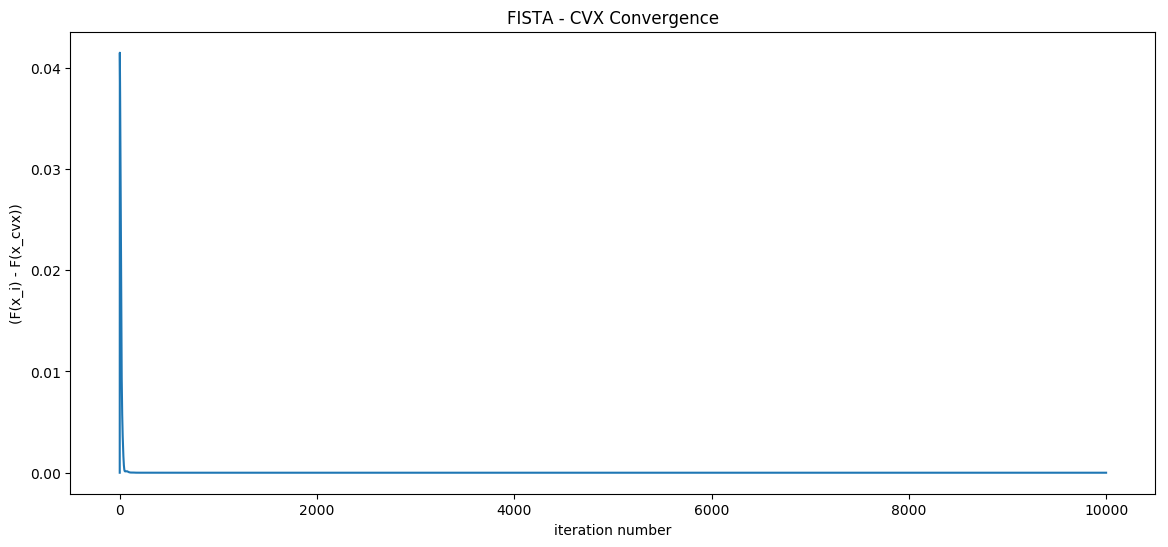

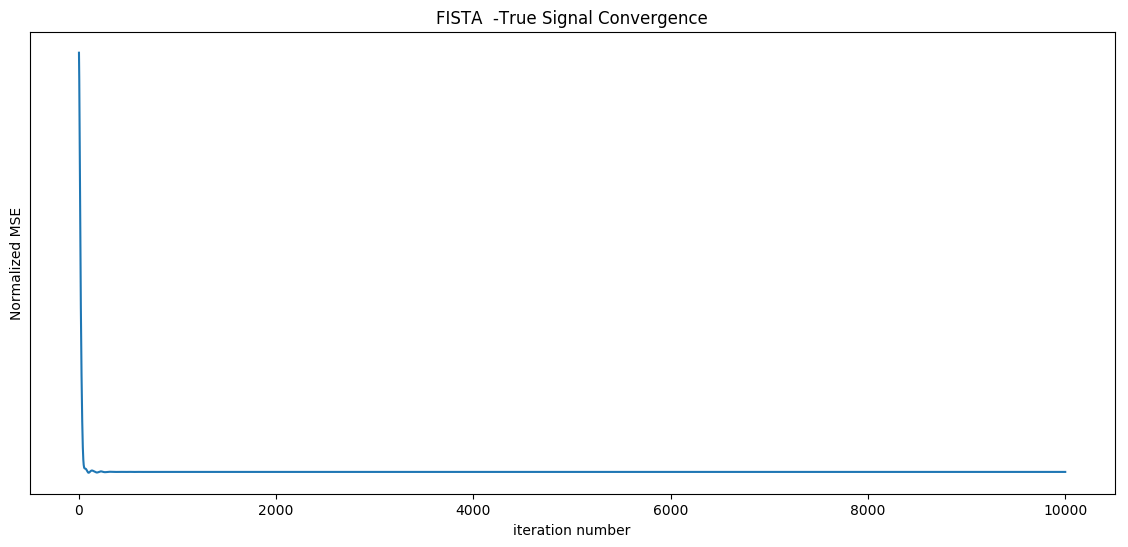

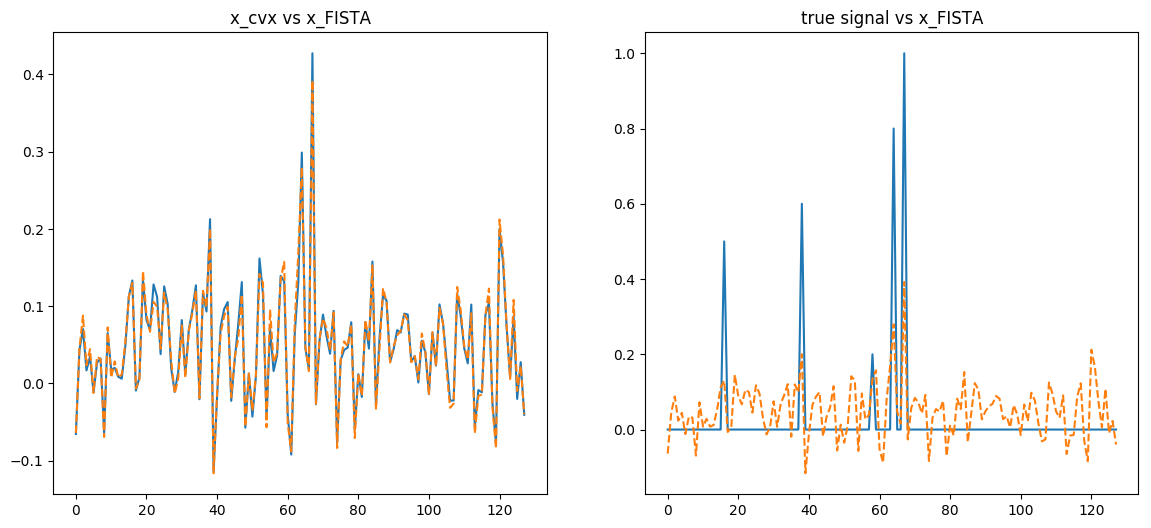

In [16]:
## FISTA

nitr = 10000
tic = time.time()
x_FISTA, F_FISTA, TSE_FISTA = FISTA(A, b, nitr, gamma, x)
toc = time.time()
fista = F(A, x_FISTA, b, gamma)
print('FISTA runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.stem(x_IST)
plt.figure(figsize=(14, 6))
plt.plot(F_FISTA - F(A, x_cvx, b, gamma))
plt.xlabel('iteration number')
plt.ylabel('(F(x_i) - F(x_cvx))')
plt.title('FISTA - CVX Convergence')

if sum(TSE_IST) > 0:
    plt.figure(figsize=(14, 6))
    plt.semilogy(TSE_FISTA/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('FISTA  -True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_cvx)
plt.plot(range(N), x_FISTA, '--')
plt.title('x_cvx vs x_FISTA')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_FISTA, '--')
plt.title('true signal vs x_FISTA')

print('F(x_fista) =', fista)
print('F(x_cvx) =', cv)

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:85: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


AMP runtime for 2000 iterations: 0.3684701919555664 seconds
2-norm(x-x_AMP) = 1.21803271461


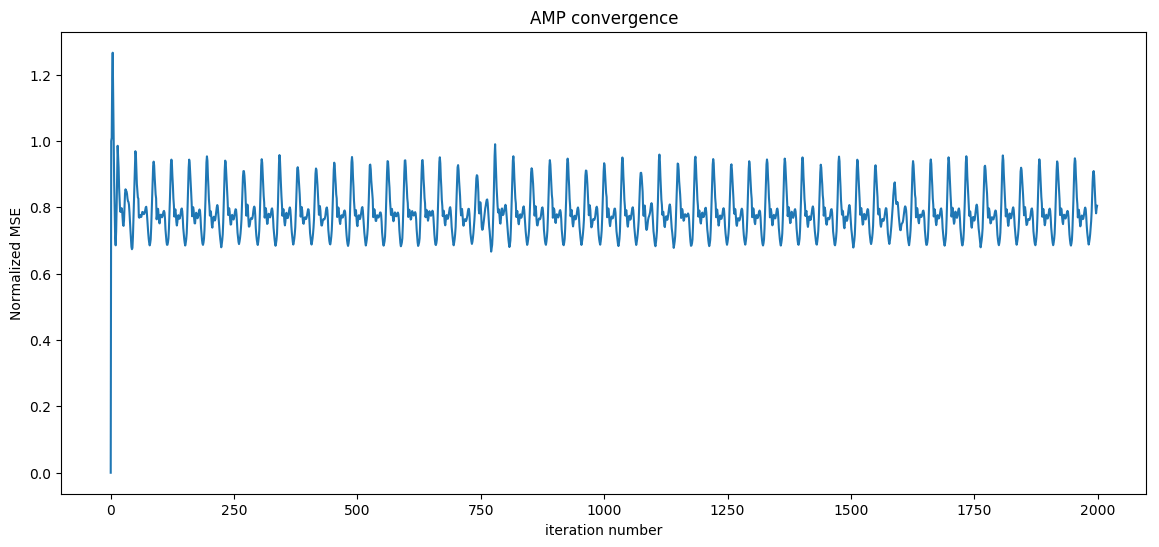

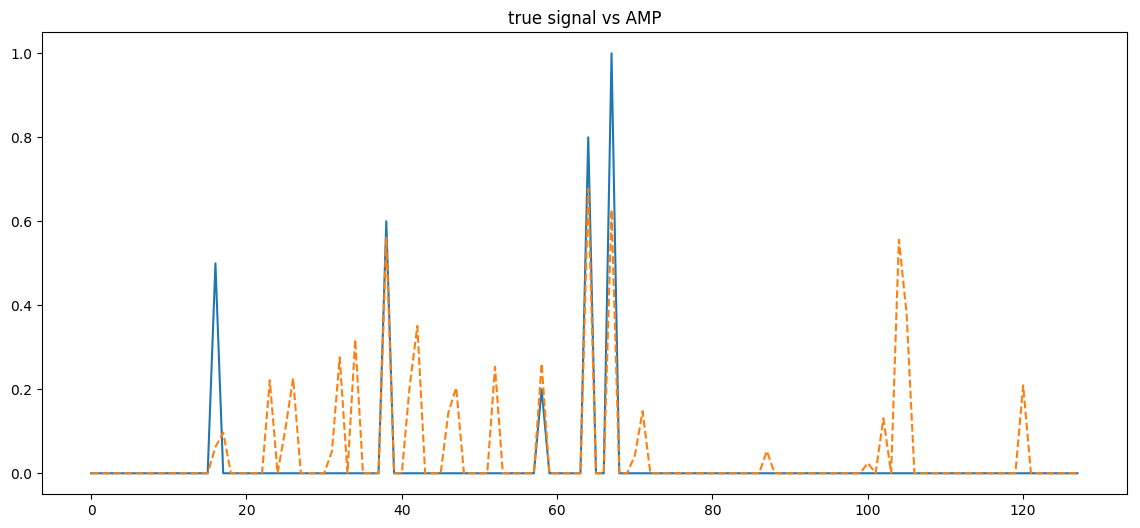

In [17]:
## AMP

nitr = 2000
cutoff = 25
tic = time.time()
x_AMP, TSE_AMP = AMP(A, b, nitr, cutoff, x)
toc = time.time()
# amp = F(A, x_AMP, b, gamma)
print('AMP runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.stem(x_AMP)
plt.figure(figsize=(14, 6))
plt.plot(TSE_AMP/np.linalg.norm(x))
plt.xlabel('iteration number')
plt.ylabel('Normalized MSE')
plt.title('AMP convergence')

plt.figure(figsize=(14, 6))
plt.plot(range(N), x, range(N), x_AMP, '--')
plt.title('true signal vs AMP')

print('2-norm(x-x_AMP) =', np.linalg.norm(x - x_AMP))
# print('F(x_cvx) =', cv)


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ADMM runtime for 10000 iterations: 17.86178994178772 seconds
F(x_ADMM) = 1.8270549692e-18
F(x_cvx) = 5.9205243532e-28


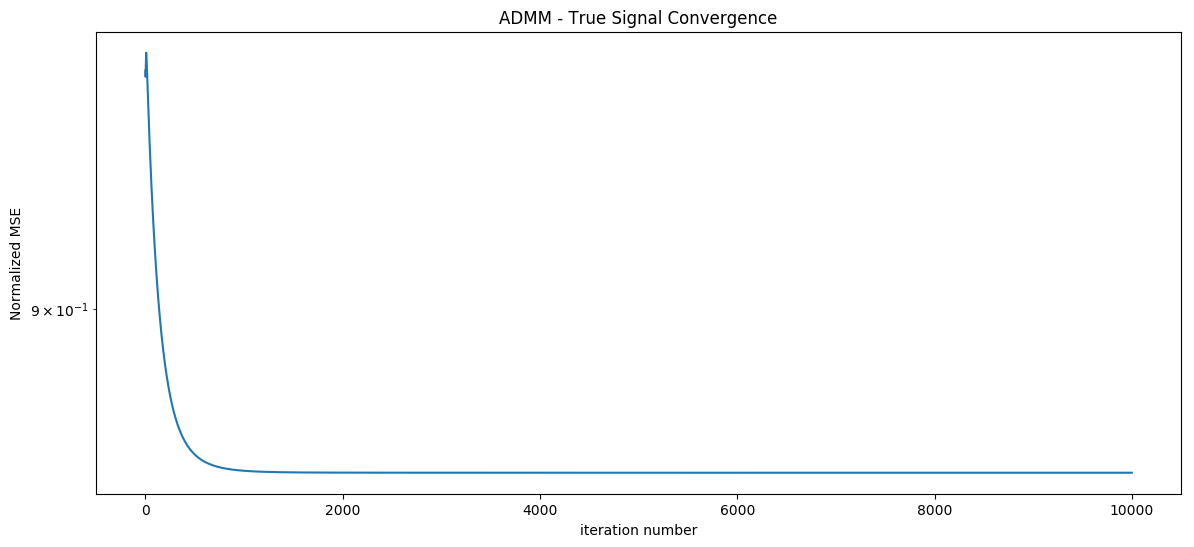

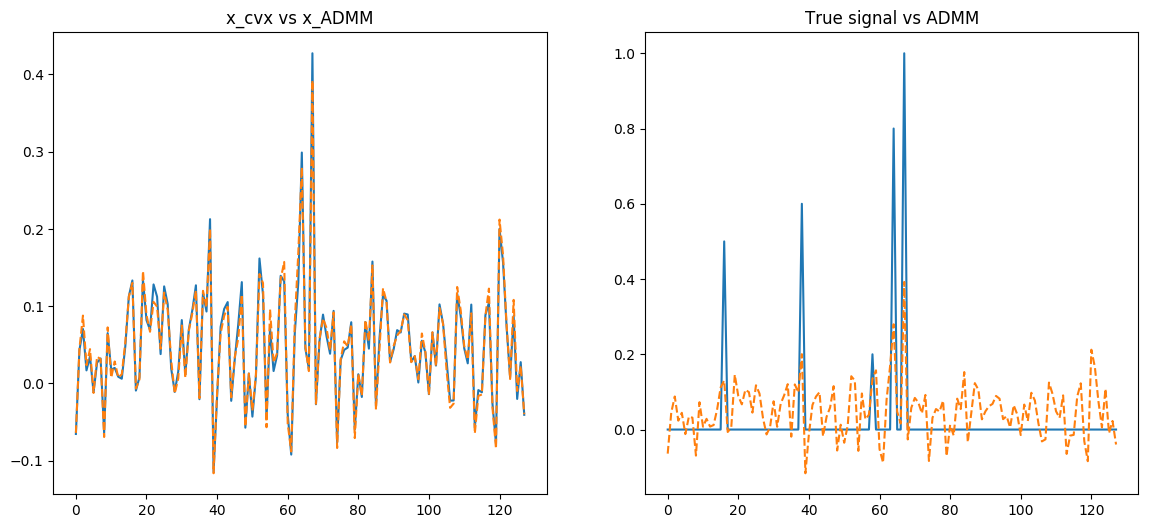

In [25]:
## def ADMM(A, y, niter, lamb, x_true=None):

nitr = 10000
tic = time.time()
x_ADMM, z_ADMM, TSE_ADMM = ADMM(A, b, nitr, gamma, x)
toc = time.time()
admm = F(A, x_ADMM, b, gamma)
print('ADMM runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.figure(figsize=(14, 6))
# plt.plot(range(nitr),admm - F(A, x_cvx, b, gamma))
# plt.xlabel('iteration number')
# plt.ylabel('(F(x_i) - F(x_cvx))')
# plt.title('ADMM - CVX Convergence')

if sum(TSE_ADMM) > 0:
    plt.figure(figsize=(14, 6))
    plt.semilogy(TSE_ADMM/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('ADMM - True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_cvx)
plt.plot(range(N), x_ADMM, '--')
plt.title('x_cvx vs x_ADMM')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_ADMM, '--')
plt.title('True signal vs ADMM')

print('F(x_ADMM) =', admm)
print('F(x_cvx) =', cv)

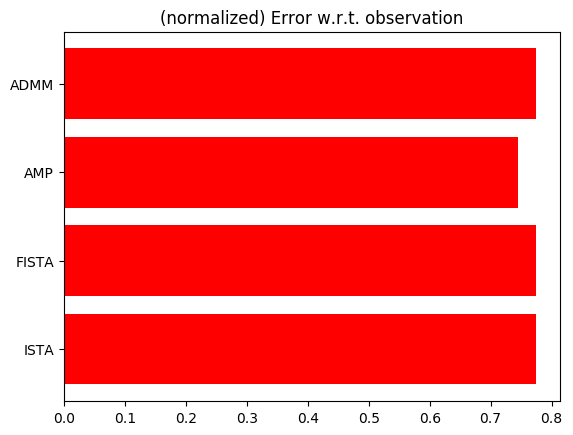

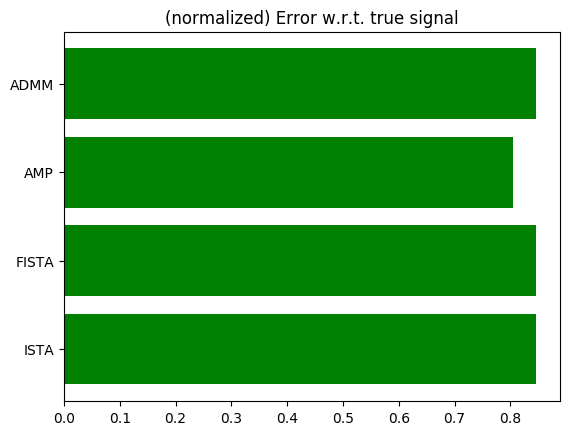

In [26]:
## Error 

# Benchmarks

plt.rcdefaults()
fig, ax = plt.subplots()

## data
ISTA_error = np.linalg.norm(y - x_IST) / np.linalg.norm(y)
FISTA_error = np.linalg.norm(y - x_FISTA) / np.linalg.norm(y)
AMP_error = np.linalg.norm(y - x_AMP) / np.linalg.norm(y)
ADMM_error = np.linalg.norm(y - x_ADMM) / np.linalg.norm(y)

methods = ('ISTA', 'FISTA', 'AMP', 'ADMM')
y_pos = np.arange(len(methods))
error1 = [ISTA_error, FISTA_error, AMP_error, ADMM_error]

## barh 
ax.barh(y_pos, error1, color='red')
ax.set_yticks(y_pos)
ax.set_yticklabels(methods)
ax.set_title('(normalized) Error w.r.t. observation')
plt.show()



plt.rcdefaults()
fig, ax = plt.subplots()

ISTA_error = np.linalg.norm(x - x_IST) / np.linalg.norm(x)
FISTA_error = np.linalg.norm(x - x_FISTA) / np.linalg.norm(x)
AMP_error = np.linalg.norm(x - x_AMP) / np.linalg.norm(x)
ADMM_error = np.linalg.norm(x - x_ADMM) / np.linalg.norm(x)
error2 = [ISTA_error, FISTA_error, AMP_error, ADMM_error]

## barh 
ax.barh(y_pos, error2, color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(methods)
ax.set_title('(normalized) Error w.r.t. true signal')
plt.show()

## Complex reconstruction

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1.10333848055
(127.185256169+0.246463826919j)


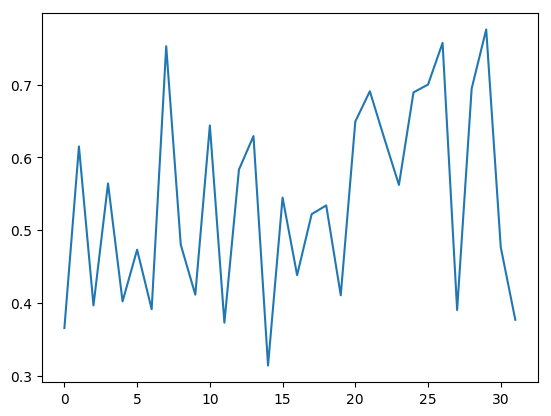

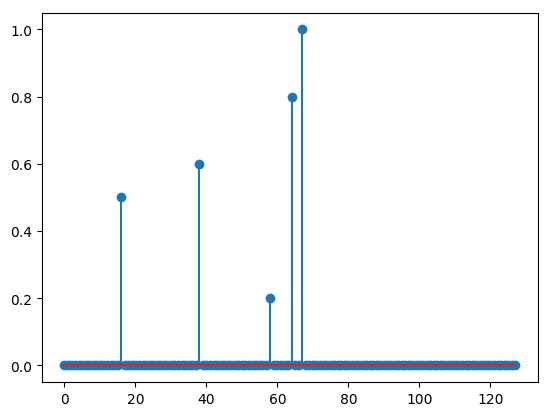

In [27]:
## Problem data
np.random.seed(1)
A = np.random.rand(n,N) + 1j * np.random.rand(n,N)

# Normalize A
A_norm = np.sqrt((A**2).sum(axis=0))
A = A / A_norm[None, :]

b = A @ x
plt.plot(b)
plt.figure()
plt.stem(x)

print(str(np.linalg.norm(A[:,1])))
print(str(np.max(np.linalg.eigvals(A.T @ A))))

numpy ls: 1.64269486268e-30


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


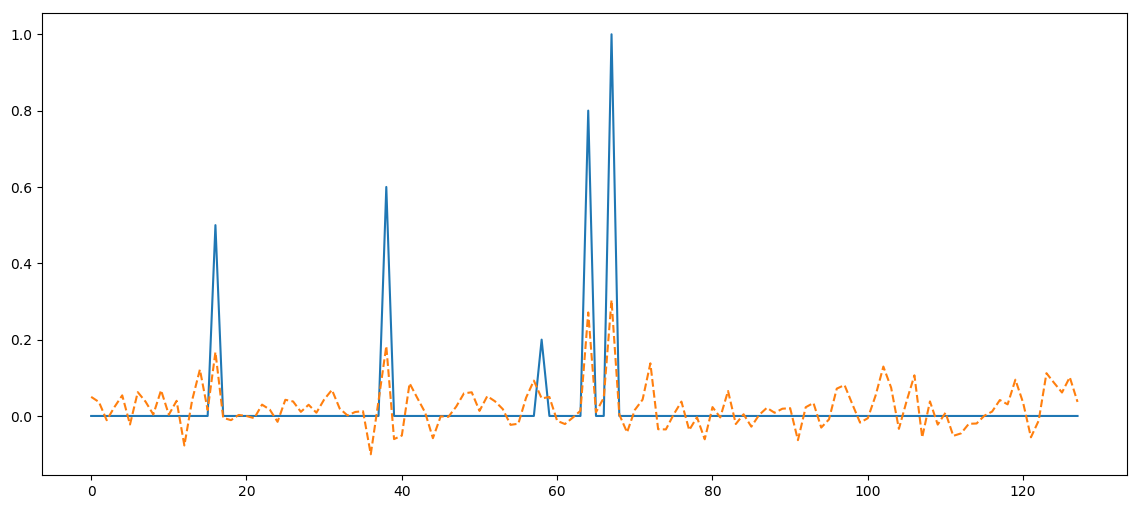

In [28]:
## LEAST SQUARES
x_ls = np.linalg.lstsq(A, b)[0]
ls = F(A,x_ls,b, gamma) 

print("numpy ls: " +str(ls))

plt.figure(figsize=(14, 6))
plt.plot(range(N), x, range(N), x_ls, '--');

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ISTA runtime for 200000 iterations: 20.727517127990723 seconds


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


F(x_ist) = 6.71658739382e-30
F(x_ls) = 1.64269486268e-30


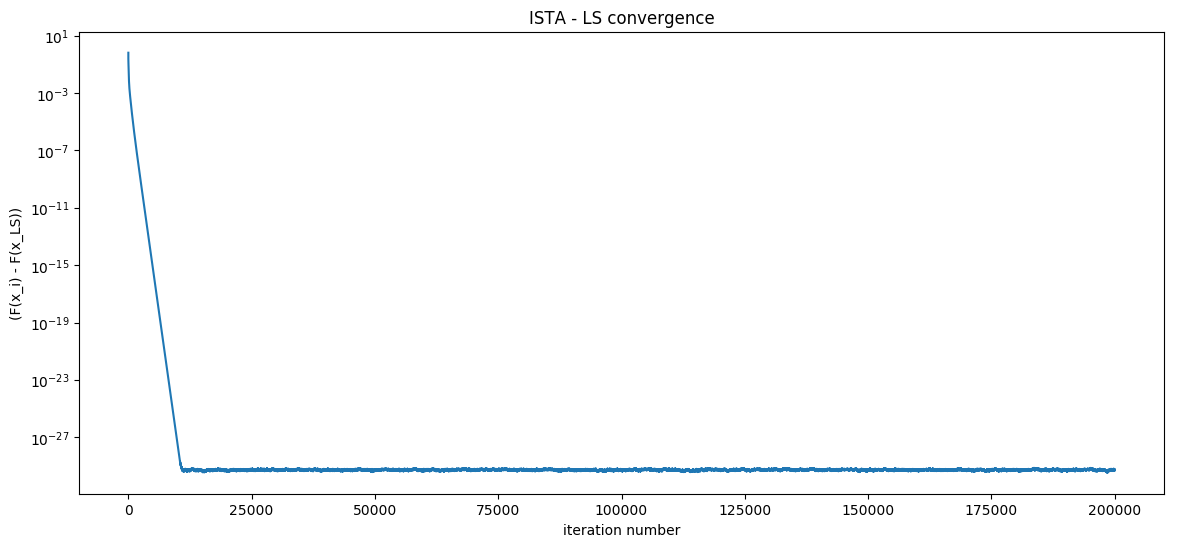

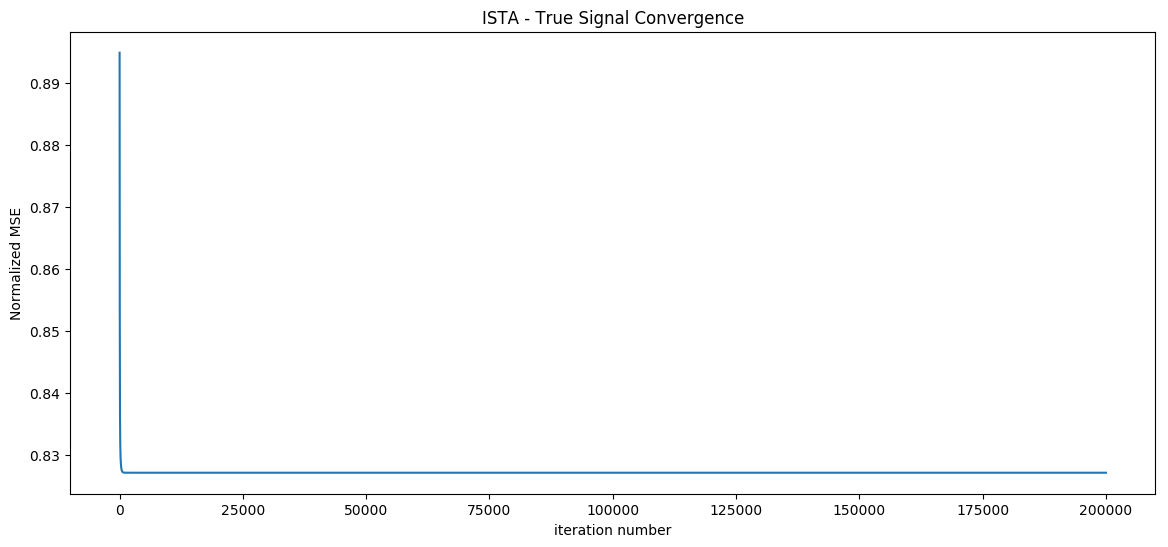

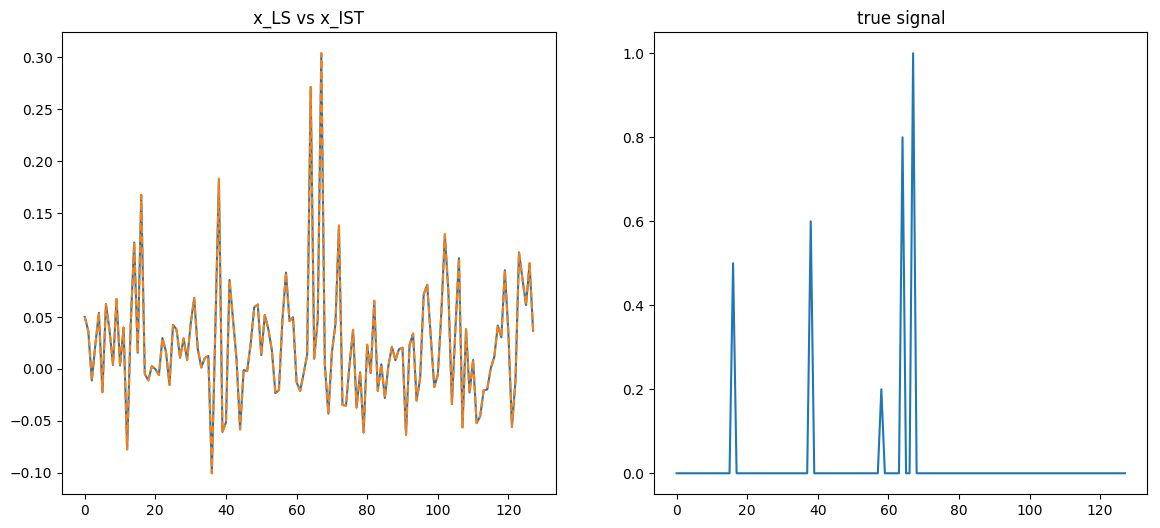

In [29]:
## ISTA

nitr = 200000
tic = time.time()
x_IST, F_IST, TSE_IST = ISTA(A, b, nitr, gamma, x)
toc = time.time()
print('ISTA runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
ist = F(A, x_IST, b, gamma)

plt.figure(figsize=(14, 6))
plt.semilogy(F_IST - F(A, x_ls, b, gamma))
plt.xlabel('iteration number')
plt.ylabel('(F(x_i) - F(x_LS))')
plt.title('ISTA - LS convergence')

if sum(TSE_IST) > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(TSE_IST/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('ISTA - True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_ls)
plt.plot(range(N), x_IST, '--')
plt.title('x_LS vs x_IST')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.title('true signal')

print('F(x_ist) =', ist)
print('F(x_ls) =', ls)

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


FISTA runtime for 10000 iterations: 1.1228852272033691 seconds


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


F(x_fista) = 4.55028628797e-26
F(x_ls) = 1.64269486268e-30


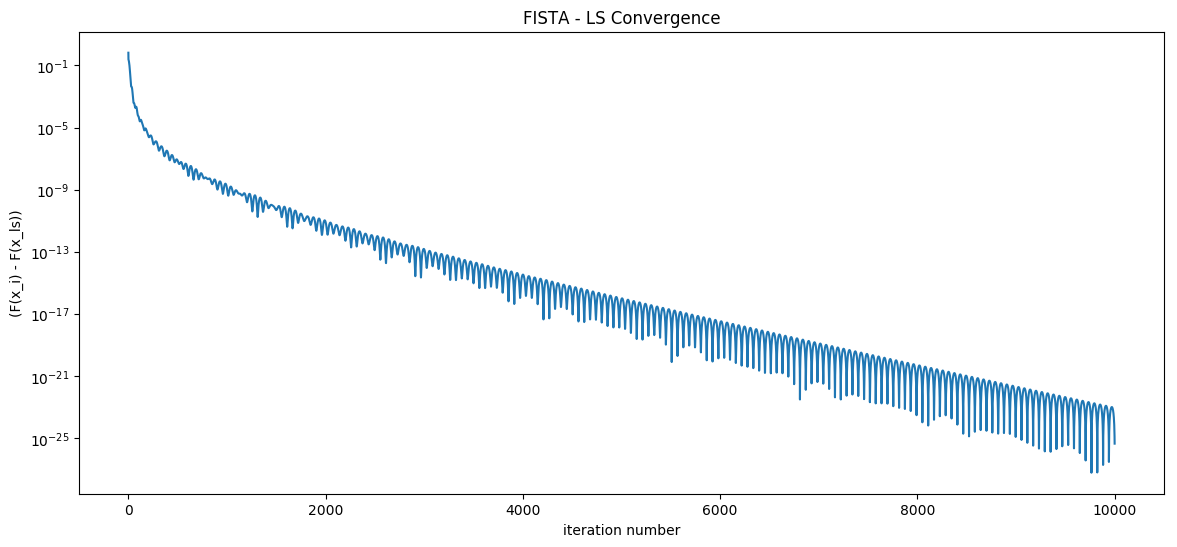

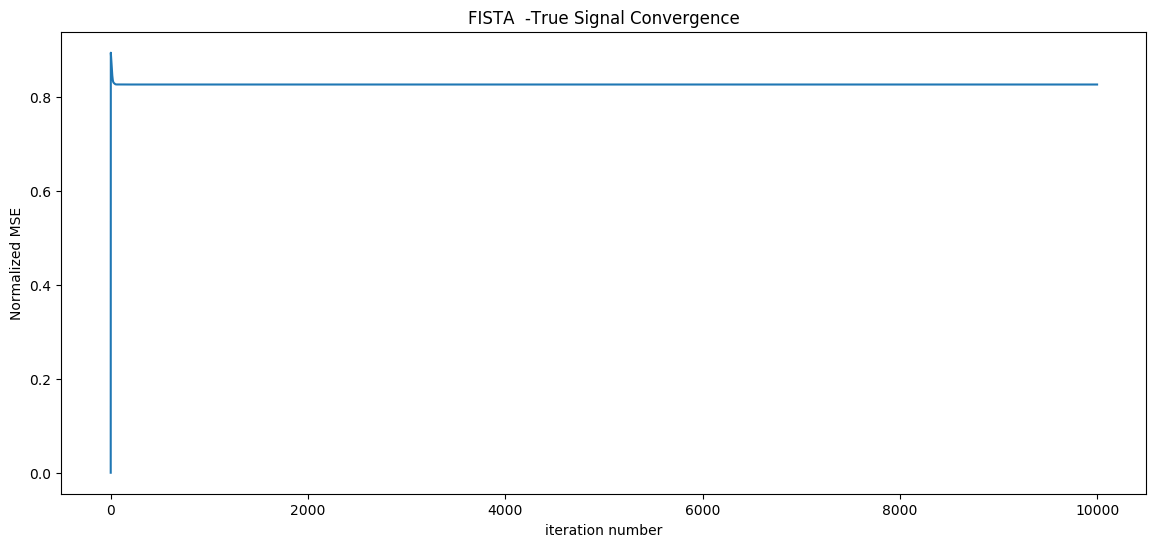

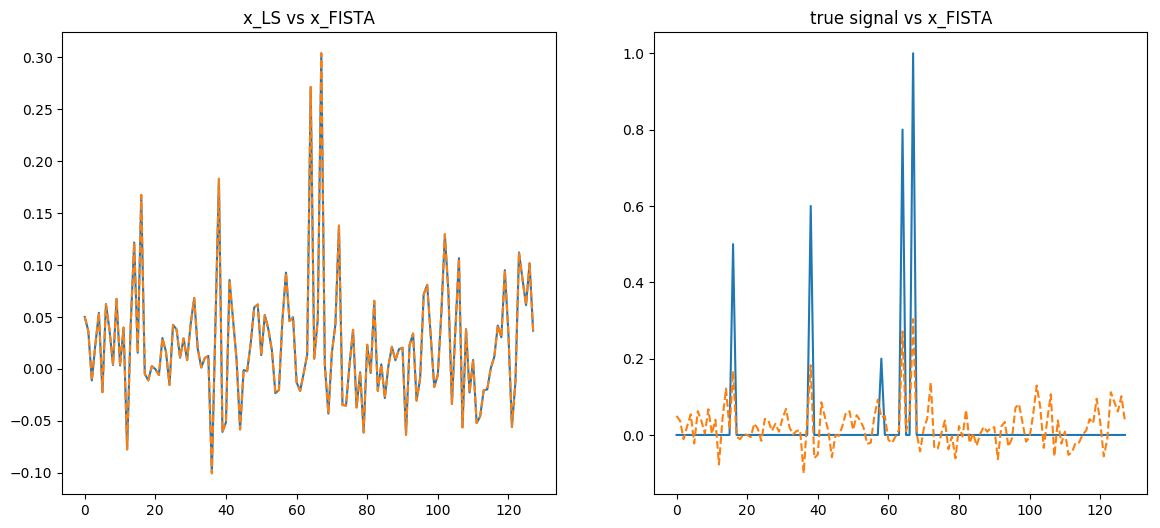

In [30]:
## FISTA

nitr = 10000
tic = time.time()
x_FISTA, F_FISTA, TSE_FISTA = FISTA(A, b, nitr, gamma, x)
toc = time.time()
fista = F(A, x_FISTA, b, gamma)
print('FISTA runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.stem(x_IST)
plt.figure(figsize=(14, 6))
plt.semilogy(F_FISTA - F(A, x_ls, b, gamma))
plt.xlabel('iteration number')
plt.ylabel('(F(x_i) - F(x_ls))')
plt.title('FISTA - LS Convergence')

if sum(TSE_IST) > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(TSE_FISTA/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('FISTA  -True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_ls)
plt.plot(range(N), x_FISTA, '--')
plt.title('x_LS vs x_FISTA')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_FISTA, '--')
plt.title('true signal vs x_FISTA')

print('F(x_fista) =', fista)
print('F(x_ls) =', ls)

complex
AMP runtime for 200 iterations: 0.07152390480041504 seconds


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:85: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/pagi/anaconda3/envs/p

2-norm(x-x_AMP) = nan


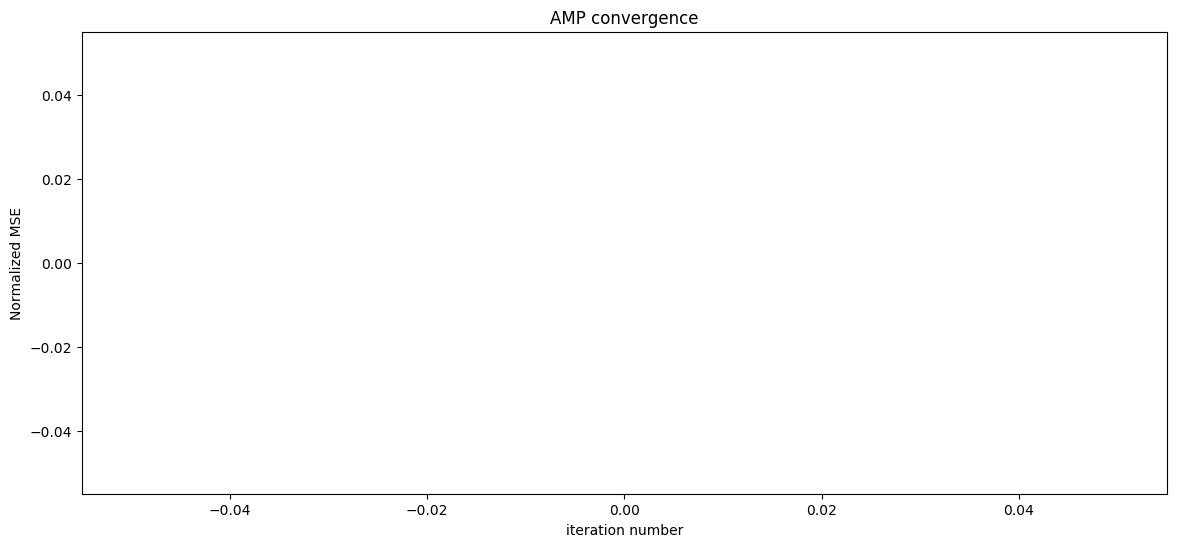

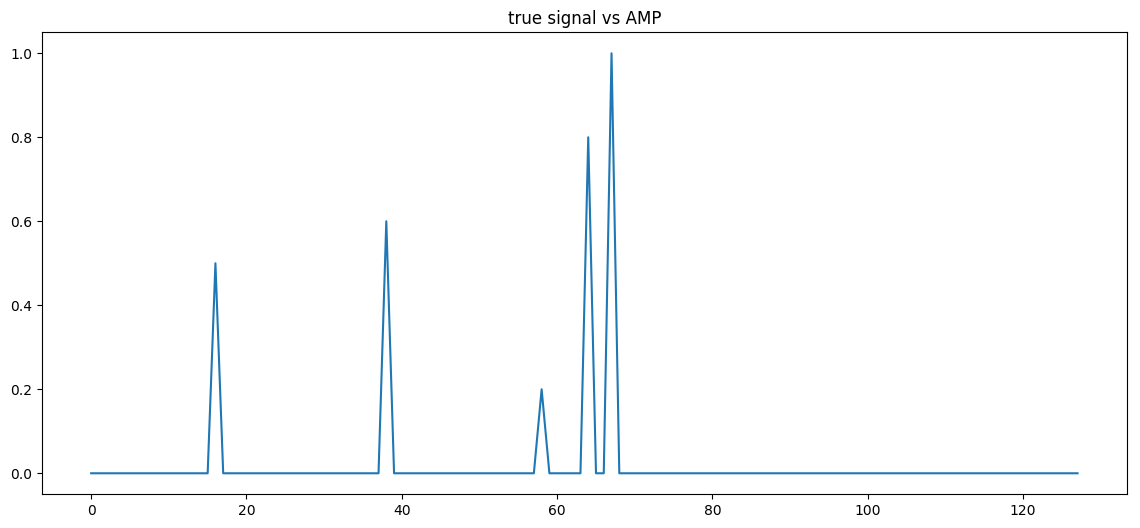

In [33]:
## AMP

nitr = 200
cutoff = 1
tic = time.time()
x_AMP, TSE_AMP = AMP(A, b, nitr, cutoff, x)
toc = time.time()
# amp = F(A, x_AMP, b, gamma)
print('AMP runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.stem(x_AMP)
plt.figure(figsize=(14, 6))
plt.plot(TSE_AMP/np.linalg.norm(x))
plt.xlabel('iteration number')
plt.ylabel('Normalized MSE')
plt.title('AMP convergence')

plt.figure(figsize=(14, 6))
plt.plot(range(N), x, range(N), x_AMP, '--')
plt.title('true signal vs AMP')

print('2-norm(x-x_AMP) =', np.linalg.norm(x - x_AMP))
# print('F(x_cvx) =', cv)


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:127: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ADMM runtime for 10000 iterations: 34.95247220993042 seconds


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


F(x_ADMM) = 1.33595120553e-15
F(x_ls) = 1.64269486268e-30


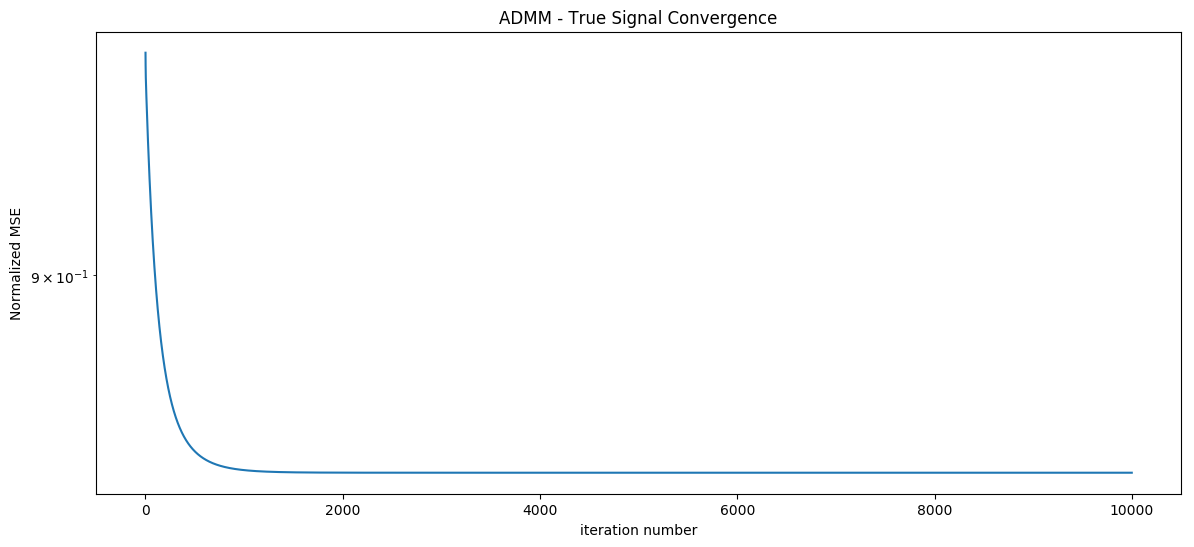

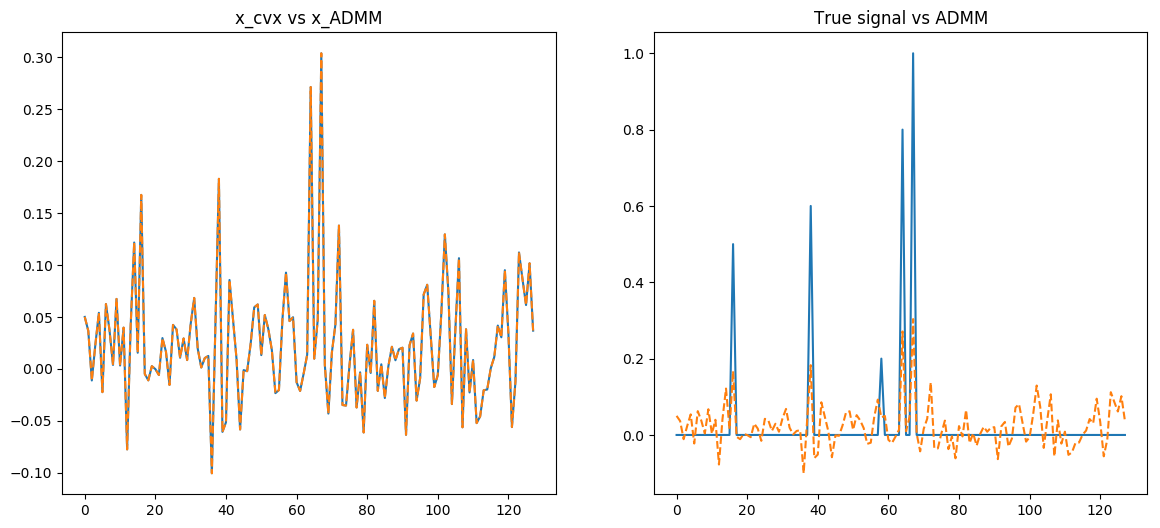

In [36]:
## def ADMM(A, y, niter, lamb, x_true=None):

nitr = 10000
tic = time.time()
x_ADMM, z_ADMM, TSE_ADMM = ADMM(A, b, nitr, gamma, x)
toc = time.time()
admm = F(A, x_ADMM, b, gamma)
print('ADMM runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.figure(figsize=(14, 6))
# plt.plot(range(nitr),admm - F(A, x_cvx, b, gamma))
# plt.xlabel('iteration number')
# plt.ylabel('(F(x_i) - F(x_cvx))')
# plt.title('ADMM - CVX Convergence')

if sum(TSE_ADMM) > 0:
    plt.figure(figsize=(14, 6))
    plt.semilogy(TSE_ADMM/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('ADMM - True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_ls)
plt.plot(range(N), x_ADMM, '--')
plt.title('x_cvx vs x_ADMM')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_ADMM, '--')
plt.title('True signal vs ADMM')

print('F(x_ADMM) =', admm)
print('F(x_ls) =', ls)